In [1]:
# Use Linear Fit xtb to fill in gaps where m06 failed

In [50]:
import os
import sys
import glob
import numpy as np

import ase.atoms
import ase.io.gaussian
import ase.visualize
import ase.optimize

# need this set to represent the RMG molecule and get the rotors
DFT_DIR = os.environ['DFT_DIR']
sys.path.append(DFT_DIR)
sys.path.append(os.environ['DATABASE_DIR'])
import autotst_wrapper
import autotst.reaction
import autotst.species
import database_fun

import rmgpy.constants

import xtb.ase.calculator

import scipy.interpolate

import arkane.ess  # just to check our answers

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def get_linear_fit(opt_files):
    m = None
    b = None
    if type(opt_files) != list:
        opt_files = [opt_files]
    xtb_energies = []
    m06_energies = []
    for opt_file in opt_files:
        with open(opt_file, 'r') as f:
            frames = ase.io.gaussian.read_gaussian_out(f, slice(None, None))

        for j in range(len(frames)):
            if not frames[j].calc.results or 'energy' not in frames[j].calc.results.keys():
                continue

            m06_energies.append(frames[j].calc.results['energy'])
            atoms = ase.Atoms(frames[j].numbers, frames[j].positions)
            atoms.calc = xtb.ase.calculator.XTB()
            xtb_energies.append(atoms.get_potential_energy())
    if len(xtb_energies) < 2:
        print('Not enough optimization points for a linear fit!')
        return m, b

        # fit a line
    m, b = np.polyfit(xtb_energies, m06_energies, 1)
    fit_energies = m * np.array(xtb_energies) + b
    corr_matrix = np.corrcoef(np.array(m06_energies), fit_energies)
    corr = corr_matrix[0, 1]
    R_sq = corr ** 2
    print(f'{len(xtb_energies)} points')
    print(f'R^2: {R_sq:.5f}')
    
    return m, b

In [42]:
# Get the rmg species
reaction_index = 714
# reaction_index = 288
direction = 'forward'
rmg_reaction = database_fun.index2reaction(reaction_index)
reaction_smiles = database_fun.reaction_index2smiles(reaction_index)

conformer_dir = os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', 'overall')
reaction_file = autotst_wrapper.get_lowest_valid_ts(conformer_dir)


reaction = autotst.reaction.Reaction(label=reaction_smiles)  # going back to this even though it's not dependable
reaction.ts[direction][0]._ase_molecule = autotst_wrapper.get_gaussian_file_geometry(reaction_file)
reaction.ts[direction][0].update_coords_from(mol_type="ase")
autotst_cf = reaction.ts[direction][0]
torsions = autotst_cf.get_torsions()
n_rotors = len(torsions)

ERROR:root:Couldn't match <Molecule "C=C[CH]C"> + <Molecule "C[CH2]"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...
ERROR:root:Couldn't match <Molecule "C=C[CH]C"> + <Molecule "C[CH2]"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...
ERROR:root:d12 distance is too large, it was measured at 3.7900400325317145 Å when the maximum allowable distance is 1.7502375000000001 Å.
ERROR:root:d23 distance is too large, it was measured at 3.7601222884188217 Å when the maximum allowable distance is 1.6014166666666665 Å.
ERROR:root:Distance between reacting atoms is too big, we cannot validate this TS through vibrational analysis.


2025-04-04 11:57:44.780513 TS is valid
2025-04-04 11:57:44.850780 Verifying bond counts for reaction 714


ERROR:root:Couldn't match <Molecule "C[CH2]"> + <Molecule "C=C[CH]C"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...
ERROR:root:Couldn't match <Molecule "C[CH2]"> + <Molecule "C=C[CH]C"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...
ERROR:root:Couldn't match <Molecule "C=C[CH]C"> + <Molecule "C[CH2]"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...
ERROR:root:Couldn't match <Molecule "C=C[CH]C"> + <Molecule "C[CH2]"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...
ERROR:root:d12 distance is too large, it was measured at 4.851490172584193 Å when the maximum allowable distance is 1.7502375000000001 Å.
ERROR:root:d23 distance is too large, it was measured at 3.855046116359829 Å when the maximum allowable distance is 1.6014166666666665 Å.
ERROR:root:Distance between reacting atoms is too big, w

2025-04-04 11:57:46.080886 TS is valid
2025-04-04 11:57:46.084967 Verifying bond counts for reaction 714


ERROR:root:Couldn't match <Molecule "C=C[CH]C"> + <Molecule "C[CH2]"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...
ERROR:root:Couldn't match <Molecule "C=C[CH]C"> + <Molecule "C[CH2]"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...
ERROR:root:d12 distance is too large, it was measured at 4.695879112542081 Å when the maximum allowable distance is 1.7502375000000001 Å.
ERROR:root:d23 distance is too large, it was measured at 3.7403616129274186 Å when the maximum allowable distance is 1.6014166666666665 Å.
ERROR:root:Distance between reacting atoms is too big, we cannot validate this TS through vibrational analysis.
ERROR:root:Couldn't match <Molecule "C[CH2]"> + <Molecule "C=C[CH]C"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...
ERROR:root:Couldn't match <Molecule "C[CH2]"> + <Molecule "C=C[CH]C"> <=> <Molecule "C=C"> + <Molecule "CC=CC"

2025-04-04 11:57:46.984932 TS is valid
2025-04-04 11:57:47.003346 Verifying bond counts for reaction 714


ERROR:root:Couldn't match <Molecule "C=C[CH]C"> + <Molecule "C[CH2]"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...
ERROR:root:Couldn't match <Molecule "C=C[CH]C"> + <Molecule "C[CH2]"> <=> <Molecule "C=C"> + <Molecule "CC=CC"> to Disproportionation, trying different combination...


In [61]:
reaction_files = glob.glob(os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', '*', '*.log'))
reaction_files += glob.glob(os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', 'overall', '*.log'))
reaction_files += glob.glob(f'/scratch/harris.se/guassian_scratch/rotor_calcs/backup/reaction_{reaction_index:06}/rotor_*/*.log')




m, b = get_linear_fit(reaction_files)

1349 points
R^2: 0.94464


In [62]:
rotor_energies = []
for rotor_index in range(n_rotors):
    atoms = autotst_cf.get_ase_mol()
    angles = np.linspace(0, 360, 73)  # every 5 degrees
#     angles = np.linspace(0, 360, 21)  # every 5 degrees
    energies = np.zeros(len(angles))

    starting_dihedral = atoms.get_dihedral(
        autotst_cf.torsions[rotor_index].atom_indices[0],
        autotst_cf.torsions[rotor_index].atom_indices[1],
        autotst_cf.torsions[rotor_index].atom_indices[2],
        autotst_cf.torsions[rotor_index].atom_indices[3],
    )

    for angle_index in range(len(angles)):
        # Reset dihedral to optimized starting point
        atoms.set_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            starting_dihedral,
            mask=autotst_cf.torsions[rotor_index].mask
        )

        # and rotate to desired increment
        atoms.rotate_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            angles[angle_index],
            mask=autotst_cf.torsions[rotor_index].mask
        )
        atoms.calc = xtb.ase.calculator.XTB()
        energies[angle_index] = m * atoms.get_potential_energy() + b
    rotor_energies.append(energies)

In [85]:
# collect the files
m06_angles = np.linspace(0, 360, 21)
all_energies = []
for rotor_index in range(n_rotors):
    energies = np.zeros_like(m06_angles) * np.nan
    for i in range(21):
        m06_rotor_file = f'/scratch/harris.se/guassian_scratch/rotor_calcs/reaction_{reaction_index:06}/rotor_{rotor_index:04}/rotor_{rotor_index:04}_{i:04}.log'
        if not os.path.exists(m06_rotor_file):
            continue
        with open(m06_rotor_file, 'r') as f:
            frames = ase.io.gaussian.read_gaussian_out(f, slice(None, None))
            for j in range(len(frames)):
                if frames[j].calc.results and 'energy' in frames[j].calc.results.keys():
                    energies[i] = frames[j].calc.results['energy']
                    break
            
    all_energies.append(energies)

In [86]:


def get_extrapolation(m06_angles, m06_energies, xtb_angles, xtb_energies, R_sq):
    if np.all(np.isnan(m06_energies)):
        return m06_energies
    
    valid_angles = [m06_angles[i] for i in range(len(m06_angles)) if not np.isnan(m06_energies[i])]
    valid_energies = [e for e in m06_energies if not np.isnan(e)]
    
    
    f_m06 = scipy.interpolate.interp1d(valid_angles, valid_energies, fill_value = "extrapolate")
    f_xtb = scipy.interpolate.interp1d(xtb_angles, xtb_energies, fill_value = "extrapolate")

    
    interpolated_values = m06_energies
    for i in range(len(m06_angles)):
        if np.isnan(m06_energies[i]):
            interpolated_values[i] = f_m06(m06_angles[i]) * (1.0 - R_sq) + f_xtb(m06_angles[i]) * R_sq
    return interpolated_values

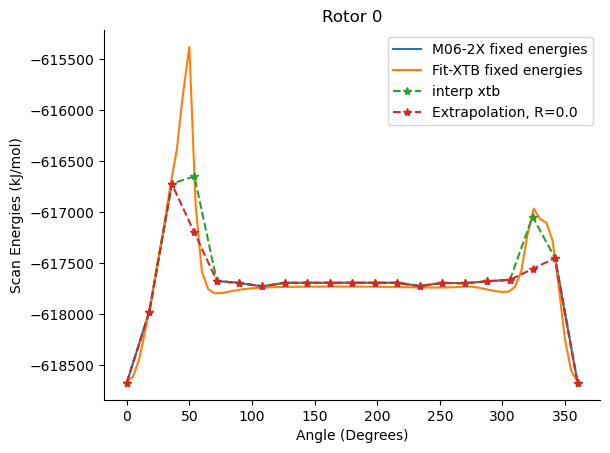

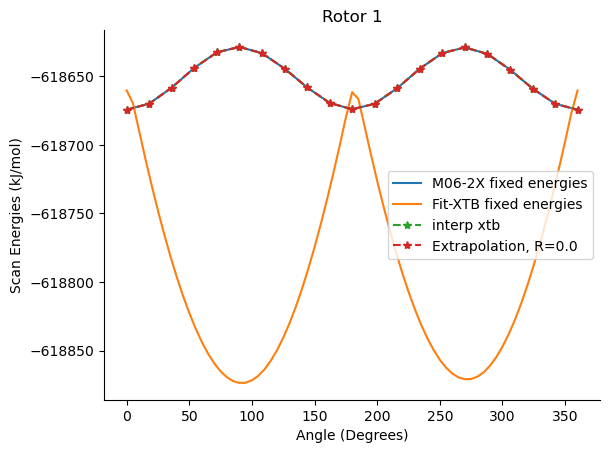

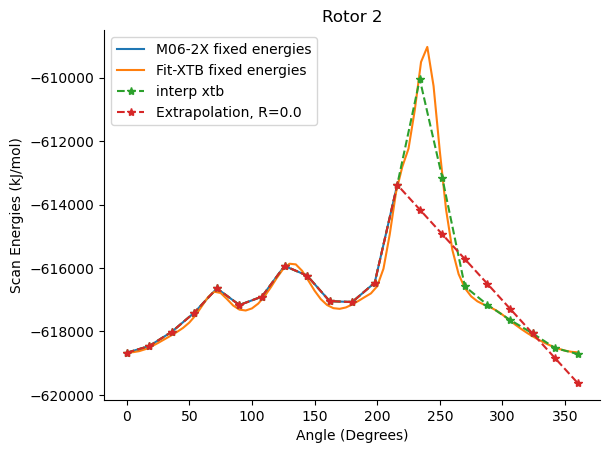

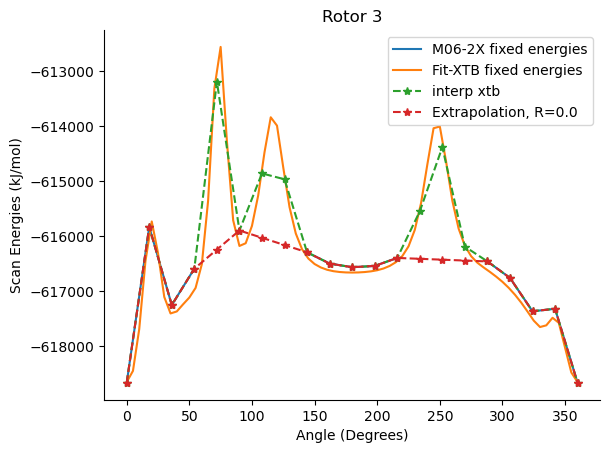

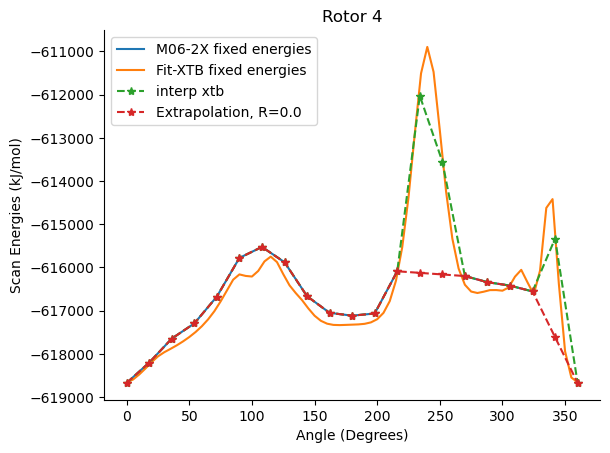

In [90]:
eV2kJ = rmgpy.constants.Na * rmgpy.constants.e / 1000.0
interpolations = []
for rotor_index in range(n_rotors):

    plt.plot(m06_angles, all_energies[rotor_index] * eV2kJ, label='M06-2X fixed energies')
    plt.plot(angles, rotor_energies[rotor_index] * eV2kJ, label='Fit-XTB fixed energies')
    
    interpolations.append(get_extrapolation(m06_angles, all_energies[rotor_index] * eV2kJ, angles, rotor_energies[rotor_index] * eV2kJ, 0.94464))
    
    plt.plot(m06_angles, interpolations[rotor_index], linestyle='dashed', marker='*', label='interp xtb')
    plt.plot(m06_angles, get_extrapolation(m06_angles, all_energies[rotor_index] * eV2kJ, angles, rotor_energies[rotor_index] * eV2kJ, 0), label='Extrapolation, R=0.0', linestyle='dashed', marker='*')
    
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    plt.xlabel(f'Angle (Degrees)')
    plt.ylabel(f'Scan Energies (kJ/mol)')
    plt.title(f'Rotor {rotor_index}')
    plt.legend()
    plt.show()

In [88]:
# assemble the scan energies -- need to check on the units
scan_dir = os.path.join('/work/westgroup/harris.se/rotor_calc/attempted_scan_files', f'reaction_{reaction_index:06}')
os.makedirs(scan_dir, exist_ok=True)

for rotor_index in range(len(interpolations)):
    scan_logfile = os.path.join(scan_dir, f'rotor_{rotor_index:04}_scan_energies.txt')
    lines = [
        'Angle (degrees)\t\tEnergy (kJ/mol)\n',
    ]
    for j in range(len(m06_angles)):
        lines.append(f'{m06_angles[j]}    {interpolations[rotor_index][j]}' + '\n')

    with open(scan_logfile, 'w') as f:
        f.writelines(lines)
